In [8]:
import sys
sys.path.append('../../')
import pandas as pd
import numpy as np
import statsmodels
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
import seaborn
import dateutil
from datetime import datetime
import math
import plotly.graph_objects as go
import plotly.express as px
import math
import functions.functions as base_fx
import functions.portfolio_functions as portfolio_fx
import functions.algorithms as algos
import functions.algorithms_kalman as algos_k

import importlib


In [9]:
importlib.reload(base_fx)
importlib.reload(portfolio_fx)
importlib.reload(algos)
importlib.reload(algos_k)



<module 'functions.algorithms_kalman' from '../../functions/algorithms_kalman.py'>

In [23]:
symbols = ['RDSA.LSE','BP.LSE']
#symbols = ['RDSA.LSE','AA','AAL.LSE','ACX.MC','AKE.PA','ANTO.LSE','APA','APD','ASH','AXTA','BHGE','BHP','BHP.LSE','BOL.ST','BP.LSE','BWY.LSE','CE','CF','CHK','CLMT','CLR','CMC','COG','COP','CRDA.LSE','CVX','CXO','DD','DK','DLN.LSE']


# Get Data

In [24]:
quotes = pd.DataFrame()
#start = '2018-01-1'
start = '2010-01-1'
end = '2020-05-25'
min_data = 252 * 4

In [25]:
for s in symbols:
    print(s)
    endpoint = f'https://eodhistoricaldata.com/api/eod/{s}?from={start}&to={end}&api_token={API_KEY}&interval=d&fmt=csv'
    df = pd.read_csv(endpoint)
    #print(df.head(1))
    df = df[df['Adjusted_close'] > 0]
    
    if len(df) < min_data: 
        print(len(df))
        continue
    #print(df.head(1))
    if len(quotes) == 0:
        quotes['Date'] = df['Date']
        quotes[s] = df['Adjusted_close']
    else:
        new_df = pd.DataFrame()
        new_df['Date'] = df['Date']
        new_df[s] = df['Adjusted_close']
        quotes = quotes.merge(new_df, how="inner", on="Date")
    #print(quotes.head(10))
#print(quotes.tail(20))

RDSA.LSE
BP.LSE


In [26]:
old_quotes = quotes
#quotes=old_quotes

print(quotes)


            Date   RDSA.LSE    BP.LSE
0     2010-01-04  1046.8589  336.2782
1     2010-01-05  1057.1592  339.8407
2     2010-01-06  1048.5229  339.4572
3     2010-01-07  1043.8823  341.5946
4     2010-01-08  1035.4738  340.7178
5     2010-01-11  1044.6902  348.2809
6     2010-01-12  1027.8841  347.3490
7     2010-01-13  1010.1333  343.4034
8     2010-01-14  1008.3674  344.3897
9     2010-01-15  1004.8433  344.7184
10    2010-01-18  1002.9458  344.7184
11    2010-01-19  1010.2647  344.9925
12    2010-01-20   994.8141  339.5121
13    2010-01-21   989.9348  334.4696
14    2010-01-22   980.8324  331.8943
15    2010-01-25   977.4910  328.2771
16    2010-01-26   975.0260  329.9213
17    2010-01-27   966.4907  325.5918
18    2010-01-28   948.7434  321.7008
19    2010-01-29   947.9631  321.6458
20    2010-02-01   953.8123  325.8660
21    2010-02-02   965.8099  313.4802
22    2010-02-03   963.8881  314.7403
23    2010-02-04   942.3699  309.6986
24    2010-02-05   933.8242  306.9035
25    2010-0

In [27]:
quotes = quotes.dropna()
quotes = quotes.reset_index()
quotes['Date'] = pd.to_datetime(quotes['Date'])
quotes = quotes.set_index('Date')
#quotes = quotes[quotes.index > dateutil.parser.parse("2020-03-01")]
#print(quotes)

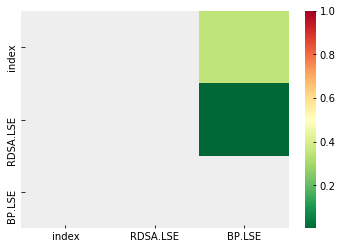

[('RDSA.LSE', 'BP.LSE', 0.0027438059926507626)]
          0       1         2
0  RDSA.LSE  BP.LSE  0.002744


In [28]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j], pvalue))
    return score_matrix, pvalue_matrix, pairs

data = quotes
scores, pvalues, pairs = find_cointegrated_pairs(data)
m = [0,0.2,0.4,0.6,0.8,1]
seaborn.heatmap(pvalues, xticklabels=data.columns, 
                yticklabels=data.columns, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.80)
                )
plt.show()
print(pairs)
pairs_df = pd.DataFrame(pairs)
pairs_df = pairs_df.sort_values(by=2)
print(pairs_df)

# Params

In [29]:
symbol1 = 'RDSA.LSE'
symbol2 = 'BP.LSE'

In [30]:
# Indicators
macd_fast_points = 1
macd_slow_points = 2
max_leverage = 2

# Could be changed
mavg_1 = 5 # default 5
mavg_2 = 40 #default 60

## Optimize trading limits looking at zscore
limit = 0.75 #default 1
exit_limit = 0.4 #default -.75
leverage_limit = 0.9

## Optimize these with bruteforce
vol_interval = 30
vol_peak_period = 365 # 1 year
vol_mean_peak_period = 60 # 2 months
coint_limit = 0.6
coint_period = 365


In [31]:
def get_settings():
    return {
    'symbol1': symbol1,
    'symbol2': symbol2,
    'mavg_1' : mavg_1,
    'mavg_2': mavg_2,
    'macd_fast_points': macd_fast_points,
    'macd_slow_points': macd_slow_points,
    'vol_interval': vol_interval,
    'vol_peak_period': vol_peak_period,
    'vol_mean_peak_period': vol_mean_peak_period,
    'limit': limit,
    'leverage_limit': leverage_limit,
    'exit_limit': exit_limit,
    'max_leverage': max_leverage,
    'coint_limit': coint_limit,
    'coint_period': coint_period
}
    


In [32]:
settings = get_settings()
portfolio, mavg_zscore = algos.pair_trade_with_zscore_limit_and_corr(settings, quotes)
        #ret, sharpe, cagr, details = algos.backtest(quotes, symbol1, symbol2)    

correlation fails 0.8517681382434894
correlation fails 0.8805064352523856
correlation fails 0.9886641525617167
correlation fails 1.0
correlation fails 1.0
correlation fails 0.9741038518287866
correlation fails 0.9280004023829992
correlation fails 0.9798553324817836
correlation fails 0.966627519284565
correlation fails 0.9533013082586005
correlation fails 0.967507217806894
correlation fails 0.9592650548973136
correlation fails 0.9628189635767153
correlation fails 0.9622900233761134
correlation fails 0.9397012778627869
correlation fails 0.9207960862804314
correlation fails 0.9240696770448895
correlation fails 0.9114804533807576
correlation fails 0.8813781435538061
correlation fails 0.8756403925646751
correlation fails 0.8842864606171916
correlation fails 0.9113954812454906
correlation fails 0.8820842191242855
correlation fails 0.8741869845535255
correlation fails 0.9083557211970016
correlation fails 0.8922660752906195
correlation fails 0.8622058368928708
correlation fails 0.8619639847489

correlation fails 0.9320203554660789
correlation fails 0.9473024177787915
correlation fails 0.9487890538554978
correlation fails 0.9461654055548719
correlation fails 0.9211090799257946
correlation fails 0.9296018218110079
correlation fails 0.9250963018620204
correlation fails 0.9349931136598064
correlation fails 0.9338693396625495
correlation fails 0.9529411148915827
correlation fails 0.9377466379502146
correlation fails 0.9296190771881501
correlation fails 0.9294464745198614
correlation fails 0.9303271079601275
correlation fails 0.9245449951312142
correlation fails 0.9246110886695905
correlation fails 0.9271343553569082
correlation fails 0.9301668551630988
correlation fails 0.9256795411783338
correlation fails 0.9235621251811309
correlation fails 0.9207596229040569
correlation fails 0.9108138423817872
correlation fails 0.9195649498970063
correlation fails 0.9158055937348842
correlation fails 0.9322891201904175
correlation fails 0.9324785245719023
correlation fails 0.9150876888481647
c

correlation fails 0.783283404236304
correlation fails 0.7753822133067246
correlation fails 0.8178735072933709
correlation fails 0.782665158365893
correlation fails 0.7751239919044179
correlation fails 0.7685674103149281
correlation fails 0.7668824587464254
correlation fails 0.7200265190660715
correlation fails 0.739265225314211
correlation fails 0.7435961362043694
correlation fails 0.7491389316171236
correlation fails 0.7529871078477918
correlation fails 0.7383412389756967
correlation fails 0.7284893487730422
correlation fails 0.7276213500141447
correlation fails 0.7368188059466448
correlation fails 0.7355976567223081
correlation fails 0.797695216198823
correlation fails 0.7964121469046014
correlation fails 0.7983765704533536
correlation fails 0.7973698064983905
correlation fails 0.7939968778254598
correlation fails 0.8006454061916348
correlation fails 0.7779190856567553
correlation fails 0.7444192982269431
correlation fails 0.7415095280159982
correlation fails 0.7428885680944978
corre

correlation fails 0.6617445033763802
correlation fails 0.6606540054914632
correlation fails 0.6525423918358934
correlation fails 0.6582011459702964
correlation fails 0.6871478713254545
correlation fails 0.6521329647285385
correlation fails 0.6573127465158026
correlation fails 0.6696715578121044
correlation fails 0.6900934522884794
correlation fails 0.6839878837790191
correlation fails 0.6981902087134276
correlation fails 0.7033818648584287
correlation fails 0.7058780362216572
correlation fails 0.707358794475923
correlation fails 0.7086868371107266
correlation fails 0.7130498835588306
correlation fails 0.701003435650128
correlation fails 0.7066325220159682
correlation fails 0.6788623141459318
correlation fails 0.6712989781251262
correlation fails 0.6717136706214779
correlation fails 0.6740433282524961
correlation fails 0.6578672097527976
correlation fails 0.664240084207347
correlation fails 0.6552812732217395
correlation fails 0.6507523368397214
correlation fails 0.6533813118581544
corr

zscore vol


ratios


returns


Return: 
60.341467113272614%
Vol:
0.07656225142638921


# Loop through each day

In [19]:
def print_kpis(dfs, sharpe, cagr):
    fig = go.Figure()


    fig.add_trace(go.Scatter(x=dfs.index, y=dfs,
                                     mode='lines',
                                     name='hi'))

    fig.show()

    #normalized = base_fx.normalize(data)

    returns = np.log(dfs / dfs.shift(1))
    vol = dfs.std() * math.sqrt(252)
    print('Return: ')
    print(str((dfs.iloc[-1] - 1) * 100) + '%')

    print('Vol:')
    print(vol)

    print('Cum Annualized')
    print(cagr * 100)

    print('Sharpe')
    print(sharpe)

In [41]:
for i,r in pairs_df.head(10).iterrows():
    for k in range(2):
        if k == 0:
            symbol1 = r[0]
            symbol2 = r[1]
            
        if k == 1:
            symbol1 = r[1]
            symbol2 = r[0]
        try:
            print(f'\n{symbol1} {symbol2}')
            #settings = get_settings()
            #hedge_ratio = get_hedge_ratio(symbol1, symbol2, quotes)
            settings = get_settings()
            ret, sharpe, cagr, details = algos_k.backtest(quotes, symbol1, symbol2)
            #ret, sharpe, cagr, details = algos.backtest(quotes, symbol1, symbol2)    
            #print('hi')
            print_kpis(ret, sharpe, cagr)
        except Exception as e:
            print(e)
            print('Failed')



RDSA.LSE CVX


Return: 
0.0%
Vol:
0.0
Cum Annualized
0.0
Sharpe
0.0

CVX RDSA.LSE


Return: 
0.0%
Vol:
0.0
Cum Annualized
0.0
Sharpe
0.0

BWY.LSE CE


Return: 
0.0%
Vol:
0.0
Cum Annualized
0.0
Sharpe
0.0

CE BWY.LSE


Return: 
0.0%
Vol:
0.0
Cum Annualized
0.0
Sharpe
0.0

CXO DD


Return: 
14.799277056543247%
Vol:
0.835430572393959
Cum Annualized
1.79
Sharpe
0.7910791905186269

DD CXO


Return: 
37.68142334237834%
Vol:
1.6499594566387088
Cum Annualized
4.2
Sharpe
0.9890726987879706

AKE.PA BOL.ST


Return: 
4.0472066971370735%
Vol:
0.21399976244851993
Cum Annualized
0.51
Sharpe
0.8003733337774634

BOL.ST AKE.PA


Return: 
3.826012851202809%
Vol:
0.2003868210373485
Cum Annualized
0.48
Sharpe
0.7812424393703702

BP.LSE CVX


Return: 
0.0%
Vol:
0.0
Cum Annualized
0.0
Sharpe
0.0

CVX BP.LSE


Return: 
0.0%
Vol:
0.0
Cum Annualized
0.0
Sharpe
0.0

COP DK


Return: 
17.784803155005147%
Vol:
0.7112868969893963
Cum Annualized
2.13
Sharpe
0.26553920046581286

DK COP


Return: 
13.447463107427726%
Vol:
0.7333697170750654
Cum Annualized
1.6400000000000001
Sharpe
0.19669901329071587

RDSA.LSE BP.LSE


Return: 
5.727944109126981%
Vol:
0.26712975054239313
Cum Annualized
0.72
Sharpe
0.9594173708665721

BP.LSE RDSA.LSE


Return: 
4.706764704465494%
Vol:
0.2641539447165436
Cum Annualized
0.59
Sharpe
0.5794619934732208

AKE.PA CMC


Return: 
0.0%
Vol:
0.0
Cum Annualized
0.0
Sharpe
0.0

CMC AKE.PA


Return: 
11.702011232962128%
Vol:
0.5179044930926794
Cum Annualized
1.44
Sharpe
0.39637430973761084

CHK CXO


Return: 
88.77814041576121%
Vol:
2.6275220786094815
Cum Annualized
8.53
Sharpe
0.6803822696733417

CXO CHK


Return: 
228.47989164038438%
Vol:
5.1510636500760505
Cum Annualized
16.55
Sharpe
1.3436043675548304

CHK CLR


Return: 
71.54254861004816%
Vol:
1.641260231634828
Cum Annualized
7.199999999999999
Sharpe
0.5427765426293513

CLR CHK


Return: 
42.15964548787756%
Vol:
1.6163207362412657
Cum Annualized
4.63
Sharpe
0.22286821923651987


## Trade

UnboundLocalError: local variable 'mavg_zscore' referenced before assignment

In [12]:
portfolio_fx.plot_trades_on_zscore_for_symbol(mavg_zscore, portfolio, symbol2)